**Sources of information** (last update)

In [1]:
#@title { vertical-output: true, display-mode: "form" }
import pandas as pd
from datetime import datetime, timedelta


# Consider adding:
#  https://github.com/COVID19Tracking

# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data
# FIPS, Admin2, Province_State, Country_Region, Last_Update, Lat, Long_, Confirmed, Deaths, Recovered, Active, Combined_Key
# Issue: US and others are broken down, while Italy for example is whole
def load_latest_johnhopkins_daily():
    tries = 3
    try_date_utc = datetime.utcnow()
    while True:
        try:
            loc_template = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/%m-%d-%Y.csv"
            try_url = try_date_utc.strftime(loc_template)
            df = pd.read_csv(try_url)
            return also_print_df(df, "John Hopkins", try_date_utc)
        except:
            try_date_utc = try_date_utc - timedelta(days=1)
            tries = tries - 1
            if tries is 0:
                print("Out of tries looking for John Hopkins' data (walking back 1 day at a time)")
                exit(1)


# https://github.com/open-covid-19
#  Date, CountryCode, CountryName, RegionCode, RegionName, Confirmed, Deaths, Latitude, Longitude, Population --- sorted by date, ascending
def load_latest_opencovid_feed():
    loc_template = "https://raw.githubusercontent.com/open-covid-19/data/master/output/data.csv"
    df = pd.read_csv(loc_template)
    last_date = datetime.strptime(df.iloc[-1]['Date'], '%Y-%m-%d')
    return also_print_df(df, "Open COVID-19", last_date)


# https://github.com/pcm-dpc/COVID-19/
#  data, stato, ricoverati_con_sintomi, terapia_intensiva, totale_ospedalizzati, isolamento_domiciliare, totale_attualmente_positivi, nuovi_attualmente_positivi, dimessi_guariti, deceduti, totale_casi, tamponi, note_it, note_en
def load_latest_italian_dpc_nationwide_by_date():
    loc_template = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
    df = pd.read_csv(loc_template)
    last_date = datetime.strptime(df.iloc[-1]['data'], '%Y-%m-%dT%H:%M:%S')
    return also_print_df(df, "Italian PCM-DPC (nationwide by date)", last_date)


#  data, stato, codice_regione, denominazione_regione, lat, long, ricoverati_con_sintomi, terapia_intensiva, totale_ospedalizzati, isolamento_domiciliare, totale_attualmente_positivi, nuovi_attualmente_positivi, dimessi_guariti, deceduti, totale_casi, tamponi, note_it, note_en
def load_latest_italian_dpc_regional_latest():
    loc_template = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-latest.csv"
    df = pd.read_csv(loc_template)
    last_date = datetime.strptime(df.iloc[-1]['data'], '%Y-%m-%dT%H:%M:%S')
    return also_print_df(df, "Italian PCM-DPC (regional snapshot)", last_date)

# MISC functions
reference_day = datetime(2020, 1, 1)
def date_to_day_of_year(date):
    return (date - reference_day).days + 1

def day_of_year_to_date(day_of_year):
    return reference_day + timedelta(days=(day_of_year - 1))

def also_print_df(df, name, date):
    print("📈 loaded " + name + " dataset (" + date.strftime("%Y-%m-%d") + "): " +
          "[" + str(len(df)) + " rows x " + str(len(df.columns)) + " columns]: " + ", ".join(list(df)) + "\n")
    return df


# Load the latest data sets
df_jh = load_latest_johnhopkins_daily()
df_oc = load_latest_opencovid_feed()
df_it_nat_daily = load_latest_italian_dpc_nationwide_by_date()
df_it_by_reg = load_latest_italian_dpc_regional_latest()

📈 loaded John Hopkins dataset (2020-03-25): [3420 rows x 12 columns]: FIPS, Admin2, Province_State, Country_Region, Last_Update, Lat, Long_, Confirmed, Deaths, Recovered, Active, Combined_Key

📈 loaded Open COVID-19 dataset (2020-03-27): [11501 rows x 10 columns]: Date, CountryCode, CountryName, RegionCode, RegionName, Confirmed, Deaths, Latitude, Longitude, Population

📈 loaded Italian PCM-DPC (nationwide by date) dataset (2020-03-26): [32 rows x 14 columns]: data, stato, ricoverati_con_sintomi, terapia_intensiva, totale_ospedalizzati, isolamento_domiciliare, totale_attualmente_positivi, nuovi_attualmente_positivi, dimessi_guariti, deceduti, totale_casi, tamponi, note_it, note_en

📈 loaded Italian PCM-DPC (regional snapshot) dataset (2020-03-26): [21 rows x 18 columns]: data, stato, codice_regione, denominazione_regione, lat, long, ricoverati_con_sintomi, terapia_intensiva, totale_ospedalizzati, isolamento_domiciliare, totale_attualmente_positivi, nuovi_attualmente_positivi, dimessi_g

***Top countries by Percentage of confirmed cases***:

In [23]:
# Date, Day_of_2020, CountryName, Confirmed, Deaths, Population, Confirmed_Share, Deaths_Share
def get_countries_data_per_day(df):
    # [select rows] remove regional data
    df = df[df['RegionCode'].isna()]

    # [snr] remove countries with no population data (Kosovo and Antilles) - for uniformity
    df = df[df['Population'].notna()]
    
    # [add column] day of the year 2020
    df['Day_of_2020'] = df['Date'].map(lambda d: date_to_day_of_year(datetime.strptime(d, '%Y-%m-%d')))

    # [select columns] take only the columns we care about
    df = df.loc[:, ['Date', 'Day_of_2020', 'CountryName', 'Confirmed', 'Deaths', 'Population']]

    # [add columns] normalize Confirmed and Deaths to the population (%)
    df['Confirmed_share'] = 100 * df['Confirmed'] / df['Population']
    df['Deaths_share'] = 100 * df['Deaths'] / df['Population']
    return df


def get_highest_share_countries(df):
    # [unique] get freshest data, unique by country
    df = df.drop_duplicates('CountryName', keep='last')

    # [snr] remove countries with fewer than 10M people
    df = df[df['Population'] > 10E+06]

    # [snr] remove countries with fewer than 1000 cases
    df = df[df['Confirmed'] > 1000]

    # [sort] by Confirmed_Share, descending
    df = df.sort_values("Confirmed", ascending=False)
    return df


# get clean daily data for all countries from the 'Open-Covid-19' dataset
countries_daily = get_countries_data_per_day(df_oc)
countries_latest_top = get_highest_share_countries(countries_daily)
countries_latest_top

,Date,Day_of_2020,CountryName,Confirmed,Deaths,Population,Confirmed_share,Deaths_share
11310,2020-03-26,86,China,81968,3293.0,1.433784e+09,0.005717,0.000230
11398,2020-03-26,86,Italy,74386,7503.0,6.055008e+07,0.122850,0.012391
11487,2020-03-26,86,United States of America,69194,1050.0,3.290649e+08,0.021027,0.000319
11500,2020-03-27,87,Spain,56188,4089.0,4.673678e+07,0.120222,0.008749
11336,2020-03-26,86,Germany,36508,198.0,8.351704e+07,0.043713,0.000237
11396,2020-03-26,86,Iran,27017,2077.0,8.291391e+07,0.032584,0.002505
11370,2020-03-26,86,France,25233,1331.0,6.512973e+07,0.038743,0.002044
11372,2020-03-26,86,United Kingdom,9529,422.0,6.753017e+07,0.014111,0.000625
11407,2020-03-26,86,South Korea,9241,131.0,5.122531e+07,0.018040,0.000256
11442,2020-03-26,86,Netherlands,6412,356.0,1.709713e+07,0.037503,0.002082


**Some chart**

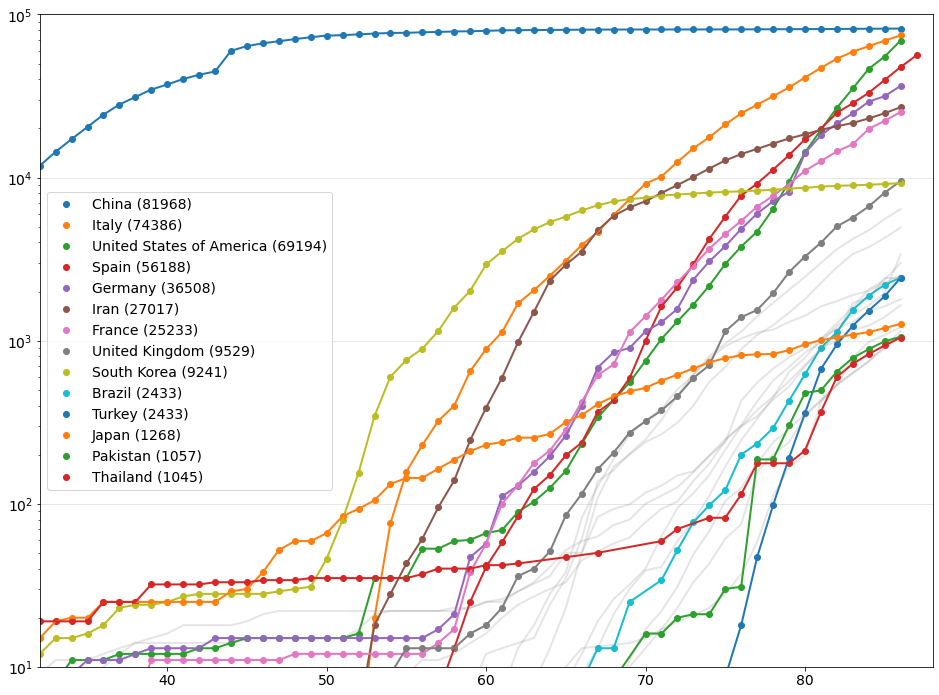

In [55]:
countries_to_chart = list(countries_latest_top['CountryName'])
highlight_population = 40E+06

import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.figure(figsize=(16, 12))
plt_axes = plt.gca()
plt_axes.grid(axis='y', color=(0.4, 0.4, 0.4), alpha=0.2)

for country in countries_to_chart:
    df = countries_daily[countries_daily['CountryName'] == country]
    df = df[df['Confirmed'] > 0] # remove 0's (very bad in log)
    x = df['Day_of_2020'].tolist()
    y = df['Confirmed'].tolist()
    latest_confirmed = df['Confirmed'].iloc[-1]
    latest_population = df['Population'].iloc[-1]
    line_highlight = latest_population > highlight_population
    line_label = country + " (" + str(latest_confirmed) +  ")"
    line_color = None if line_highlight else (0.5, 0.5, 0.5, 0.2)
    line_width = 1
    plt.plot(x, y, color=line_color, linewidth=2) # color=(0.92, 0.26, 0.21)
    if line_highlight:
        plt.scatter(x, y, label=line_label, color=line_color, linewidth=line_width, alpha=1)

#t = np.arange(0.01, 20.0, 0.01)
#plt.semilogy(t, np.exp(-t/5.0))
plt.yscale('log')
#plt.stackplot(x, y, color=(0.92, 0.26, 0.21, 0.3), linewidth=0)
#plt.xlim(int(min(x)), int(max(x) + 5))
#plt.xlim("2020-02-01", "2020-03-30")
plt.xlim(date_to_day_of_year(datetime(2020, 2, 1)), date_to_day_of_year(datetime.now()) + 2)
plt.ylim(10, 1E+05)
#plt.title("Daily increase in the infected population")
#plt.xlabel("Day of the year, 2020")
#plt.ylabel("Daily % increase")
plt.legend()
plt.show()